<div class="alert alert-block alert-info">
<b>Note:</b> This notebook is written to compile the ECCO sea ice velocity field from 1992 to 2017 into a single dataset. The final product will show "sea-ice" velocity everywhere because it is not 'masked' with sea ice concentration data.</div>

## Set up

In [10]:
%%time
import numpy as np
import xarray as xr
import os
import time
import sys
import glob  
import netCDF4  
import pandas as pd  
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime
from os.path import join,expanduser,exists,split
import cartopy as cartopy
import importlib
import matplotlib.cm as cm
from pathlib import Path
from pprint import pprint
import xgcm as xgcm
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

CPU times: user 1.06 ms, sys: 317 µs, total: 1.37 ms
Wall time: 1.31 ms


### Import ECCO_v4_Python libraries

In [2]:
user_home_dir = expanduser('/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/')
sys.path.append(join(user_home_dir,'ECCO-v4-Python-Tutorial'))
sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco
from ecco_v4_py import get_llc_grid as get_llc_grid
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_access as ea

## Prepare sea ice velocity

<code style="background:yellow;color:black">Algortihm tree (high-level overview)</code>

> **Setup**
>> Easy: Define directory paths, grid file, and range of years to process (`1992-2017`).
>> 
>> Medium: Load `ecco_grid` and initialize the `XGCM_grid` object for interpolation.
>> 
>> Easy: Initialize empty lists, `u_lambda_list` and `v_phi_list`, to store processed yearly data.

> **Processing Loop for Each Year**

>> Loop starts: For each `year` in `years`:
>>
>> 
>>> Fancy style: Start timer and print progress message.
>>> 
>>> Step 1: Load the yearly sea ice velocity data (`ds`).
>>> 
>>> Step 2: Merge `ds` with `ecco_grid` to add grid information, and kick out unnecessary variables so that it can breathe during this hectic operation.
>>> 
>>> Step 3: Mask land pixels in `SIuice` and `SIvice` using `maskW` and `maskS`.
>>> 
>>> Step 4: Delete `SIuice` and `SIvice` to free memory and let it smile.
>>> 
>>> Step 5: Apply chunking to `ds_merged` to enable efficient parallel processing (although I noticed it does not make much difference).
>>> 
>>> Step 6: Most important. Interpolate masked `u_x` and `v_y` using `XGCM_grid`.
>>> 
>>> Step 7: Rotate interpolated data to obtain zonal (`u_lambda`) and meridional (`v_phi`) velocities.
>>> 
>>> Step 8: (Optional) Add metadata (attributes) to `u_lambda` and `v_phi`.
>>> 
>>> Step 9: Append `u_lambda` and `v_phi` for the current year to the lists.
>>>
>>> Step 10: Kick out intermediate variables to free memory.
>>> 
>>> Step 11: Posh: End timer and print the processing time for the current year.
>>> 

> **Post-Loop: Concatenate and Finalize Dataset**

>> Concatenate all yearly `u_lambda` and `v_phi` data along the time dimension to create `ecco_ds`.
>> 
>> Delete lists used for concatenation to free memory.
>> 
>> Print the final dataset structure (`ecco_ds`) to verify contents and attributes.


In [3]:
# Path to data directory and grid file
ecco_dir = '/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/data/'
os.chdir(ecco_dir)
grid_file = 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc'
years = range(1992, 2018)  # First 5 years

# Load the grid file and initialize the XGCM grid object
ecco_grid = xr.open_dataset(grid_file)
XGCM_grid = get_llc_grid(ecco_grid)

# Initialize empty lists 
u_lambda_list = []
v_phi_list = []

# Process each year with Daniel's algorithm
for year in years:
    start_time = time.time()
    print(f"Processing year: {year}")
    
    # Load the year's file
    file_name = ecco_dir + f'ecco_sea_ice_velocity_{year}.nc'
    
    with xr.open_dataset(file_name) as ds:
        # Merge with grid dataset and kick out unwanted` variables to save memory
        ds_merged = xr.merge((ds, ecco_grid)).drop_vars(
            ['rA', 'dxG', 'dyG', 'rAz', 'rAw', 'rAs', 'drC', 'drF', 
             'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS']
        )
        
        # Mask land pixels for u and v velocities
        u_x = ds_merged.SIuice.copy(deep=True) * ds_merged.maskW.isel(k=0)
        v_y = ds_merged.SIvice.copy(deep=True) * ds_merged.maskS.isel(k=0)
        
        # Delete original SIuice and SIvice variables to save memory
        del ds_merged['SIuice'], ds_merged['SIvice']
        
        # Apply chunking for efficient parallel processing
        ds_merged = ds_merged.chunk({'time': 100, 'tile': 5, 'j': 45, 'i': 45})
        
        # Interpolate and rotate using XGCM grid
        vec_u_to_ij = XGCM_grid.interp_2d_vector({'X': u_x, 'Y': v_y}, boundary='fill')
        u_lambda = (vec_u_to_ij['X'] * ds_merged['CS'] - vec_u_to_ij['Y'] * ds_merged['SN']).compute()
        v_phi = (vec_u_to_ij['X'] * ds_merged['SN'] + vec_u_to_ij['Y'] * ds_merged['CS']).compute()
        
        # Add attributes to u_lambda and v_phi
        u_lambda.name = 'u_lambda'
        v_phi.name = 'v_phi'
        
        u_lambda.attrs.update({
            'long_name': 'zonal velocity',
            'units': 'm s-1'
        })
        
        v_phi.attrs.update({
            'long_name': 'meridional velocity',
            'units': 'm s-1'
        })
        
        # Append the yearly rotated velocities with attributes to the lists
        u_lambda_list.append(u_lambda)
        v_phi_list.append(v_phi)
        
        # Clear memory by deleting unneeded variables
        del vec_u_to_ij, u_x, v_y, ds_merged
        
    # Calculate and print the time taken for the current year
    end_time = time.time()
    print(f"Completed year {year} in {end_time - start_time:.2f} seconds")

# Concatenate all yearly data along the time dimension
ecco_ds = xr.Dataset({
    'u_lambda': xr.concat(u_lambda_list, dim='time'),
    'v_phi': xr.concat(v_phi_list, dim='time')
})

# Optional: Free up memory
del u_lambda_list, v_phi_list

# Verify final dataset structure
print(ecco_ds)


Processing year: 1992
Completed year 1992 in 8.41 seconds
Processing year: 1993
Completed year 1993 in 8.03 seconds
Processing year: 1994
Completed year 1994 in 8.19 seconds
Processing year: 1995
Completed year 1995 in 8.34 seconds
Processing year: 1996
Completed year 1996 in 8.25 seconds
Processing year: 1997
Completed year 1997 in 8.05 seconds
Processing year: 1998
Completed year 1998 in 8.45 seconds
Processing year: 1999
Completed year 1999 in 8.20 seconds
Processing year: 2000
Completed year 2000 in 8.23 seconds
Processing year: 2001
Completed year 2001 in 8.36 seconds
Processing year: 2002
Completed year 2002 in 8.42 seconds
Processing year: 2003
Completed year 2003 in 8.24 seconds
Processing year: 2004
Completed year 2004 in 8.44 seconds
Processing year: 2005
Completed year 2005 in 8.60 seconds
Processing year: 2006
Completed year 2006 in 8.71 seconds
Processing year: 2007
Completed year 2007 in 8.49 seconds
Processing year: 2008
Completed year 2008 in 8.48 seconds
Processing yea

In [4]:
# Drop specified variables and coordinates from the dataset
ecco_ds = xr.merge((ecco_ds, ecco_grid)).compute().drop_vars(
    ['rA', 'dxG', 'dyG', 'rAz', 'rAw', 'rAs', 'drC', 'drF', 
     'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 
     'k', 'k_u', 'k_l', 'k_p1', 'Z', 'Zp1', 'Zu', 'Zl', 
     'XC_bnds', 'YC_bnds', 'Z_bnds']
)

# Verify the structure of the dataset to ensure the specified coordinates were removed
ecco_ds
del ecco_grid

In [5]:
ecco_ds

<xarray.Dataset>
Dimensions:   (i: 90, j: 90, tile: 13, time: 9497, i_g: 90, j_g: 90, k: 50)
Coordinates:
  * i         (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j         (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile      (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC        (tile, j, i) float32 -111.6 -111.3 -110.9 ... -99.42 -105.6 -111.9
    YC        (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
  * i_g       (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    XG        (tile, j_g, i_g) float32 -115.0 -115.0 -115.0 ... -102.9 -109.0
    YG        (tile, j_g, i_g) float32 -88.18 -88.32 -88.46 ... -87.99 -88.02
Dimensions without coordinates: time, k
Data variables:
    u_lambda  (time, tile, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    v_phi     (time, tile, j, i) float32 nan nan nan nan nan ... nan nan nan nan
    CS        (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN        (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    Depth     (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    dxC       (tile, j, i_g) float32 1.558e+04 1.559e+04 ... 2.387e+04 2.341e+04
    dyC       (tile, j_g, i) float32 1.156e+04 1.159e+04 ... 1.559e+04 1.558e+04
    maskC     (k, tile, j, i) bool False False False False ... False False False
    maskW     (k, tile, j, i_g) bool False False False ... False False False
    maskS     (k, tile, j_g, i) bool False False False ... False False False

### Save variable

In [7]:
# # Save the ecco_grid dataset to a NetCDF file
# ecco_ds.to_netcdf('sea_ice_vel_without_mask_1992_2017.nc')
# print("ecco_grid saved successfully.")

# Prepare compression settings for each variable in ecco_grid
compression_settings = {var: {'zlib': True, 'complevel': 5} for var in ecco_ds.data_vars}

# Save with compression
ecco_ds.to_netcdf('sea_ice_vel_without_mask_1992_2017.nc', engine='netcdf4', encoding=compression_settings)
print("Compressed ecco_grid saved successfully.")


Compressed ecco_grid saved successfully.


### Plot

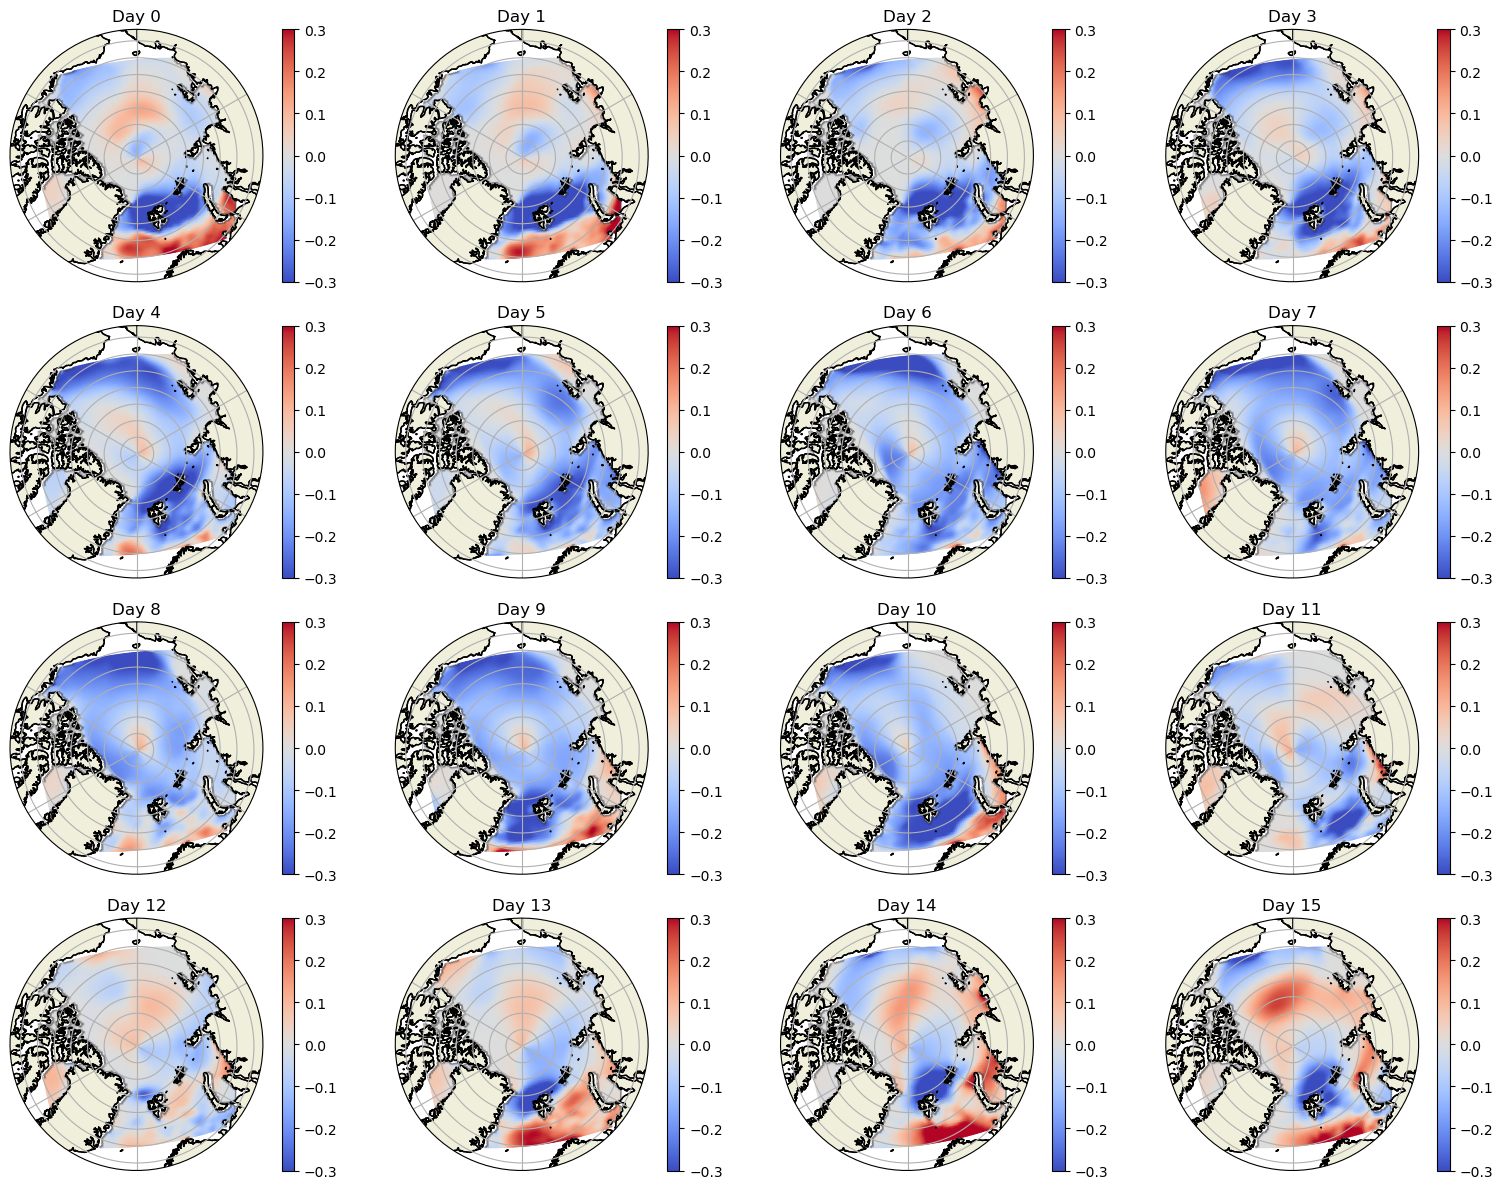

In [25]:
import importlib
import sys
sys.path.append('/Users/aahmed78/')
import plot_arctic 
importlib.reload(plot_arctic)
from plot_arctic import plot_arctic

# Define parameters for plotting multiple days
num_days = 16  # from day 0 to day 15
tile = 6

# Generate lists for data, titles, colormaps, vmin, and vmax dynamically
data_list = [ecco_ds.u_lambda.isel(tile=tile, time=day) for day in range(num_days)]
titles = [f"Day {day}" for day in range(num_days)]
cmaps = ["coolwarm"] * num_days
vmin = [-0.3] * num_days
vmax = [0.3] * num_days
colorbar_labels = ["ms-1"] * num_days

# Coordinates (fixed for the tile)
x_coords = ecco_ds.XG.isel(tile=tile)
y_coords = ecco_ds.YG.isel(tile=tile)

# Plot all days in a single 4x4 grid (16 subplots)
plot_arctic(
    data_list, x_coords, y_coords, 
    titles=titles, cmaps=cmaps, 
    vmin=vmin, vmax=vmax, colorbar_labels=False,
    nrows=4, ncols=4, figsize=(16, 12)
)

del data_list, data, x_coords, y_coords

# Check variable size

<div class="alert alert-block alert-danger">
<b>Troubleshoot:</b> In case you need to know which varibales are causing havoc (huge size), you can follow the steps and delete the big size variables.
</div>

To run this code, you first need to install pympler. In a notebook cell, just type `%pip install pympler`. It will install it automatically. And then, write down the block of codes.

In [26]:
ecco_ds.close()

sys.path.append('/Users/aahmed78/')
# In case you don't have it installed, install it simply by just running it here.
# %pip install pympler pandas
import memory_utils
# List and sort variables by memory usage
# top_n=10 means it is now displaying the top 10 largest size variable
memory_utils.list_sorted_vars(globals(), top_n=20)


                Variable    Size (MB)
0                ecco_ds  8038.659992
1                      b  4001.094960
2                      a  4001.094960
3                      c  4001.094960
4                  v_phi   154.600104
5               u_lambda   154.600104
6                     In     0.019920
7   compression_settings     0.003432
8                 titles     0.001080
9                  cmaps     0.000248
10       colorbar_labels     0.000240
11                  vmin     0.000208
12                  vmax     0.000208
13             file_name     0.000136
14              ecco_dir     0.000112
15         user_home_dir     0.000104
16             grid_file     0.000096
17                 years     0.000048
18                  tile     0.000032
19              num_days     0.000032


In [ ]:
del a, b, c